# ModAna_at_Mooring
Test modal reconstruction and barotropic/baroclinic decomposition at mooring location (using mooring data). Compare:
* values at surface
* values in the interior
* vertically integrated stuffs
for SSE, HKE and flux

In [51]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from netCDF4 import Dataset
import sys
import scipy.signal as sig
import scipy.interpolate as itp
sys.path.append('/home/lahaye/Coding/Python_ROMS_Modules/lahaye/')
from emooring import emooring
import gsw
from dynmodes_fs import dynmodes_fs as dynmodes
from SL_chebsolve import SL_chebsolve as chemodes

In [203]:
krypton = "/data0/project/vortex/lahaye/"
season = "winter"
simul = "luckyt"
imx, jmy = 1027, 968
if simul == "luckyt":
    if season == "summer":
        it1, it2 = 0, 480
    elif season == "winter":
        it1, it2 = 2880, 3360
else:
    it1, it2 = 360, 720
nmods = 10

moor_name = krypton+"moorings_from_simus/{0}_column_i{1:04d}_j{2:04d}.nc".format(simul, imx, jmy)
if simul in ["luckyto"]:
    fname = "{0}_modemap/{0}_modemap.{1:0d}_{2:0d}.nc".format(simul,int(jmy/2002.*8),int(imx/2002.*8))
else:
    fname = "{0}_modemap/{0}_modemap.nc".format(simul)
mode_name = krypton+fname


In [204]:
# load "emooring" fields
emoor = emooring(moor_name,itmin=it1,itmax=it2)
print("variables loaded:",emoor.variables.keys())

# FIX A LA MAIN
if simul in ['luckyto']:
    emoor.variables['xi_rho'] = np.arange(1025, 1030)
    emoor.variables['eta_rho'] = np.arange(966, 971)
print("time indices: from {0} to {1}".format(emoor.time[0], emoor.time[-1]))

variables loaded: dict_keys(['temp', 'ubar', 'topo', 'lat_rho', 'time', 'zeta', 'salt', 'eta_rho', 'scrum_time', 'pn', 'u', 's_rho', 'vbar', 'zwb', 'zrb', 'w', 'lon_rho', 'xi_rho', 'pm', 'v', 's_w'])
time indices: from 2880 to 3359


In [4]:
# load modes: (if you want to recompute the modes, see other cell)
nc = Dataset(mode_name, "r")
ncvar = nc.variables
xi = ncvar['xi_rho']
eta = ncvar['eta_rho']
ix, = np.where( (xi>=emoor.variables['xi_rho'].min()) & (xi<=emoor.variables['xi_rho'].max()) )
iy, = np.where( (eta>=emoor.variables['eta_rho'].min()) & (eta<=emoor.variables['eta_rho'].max()) )
ix, iy = ix[0], iy[0]
xi, eta = xi[ix], eta[iy]
print("dealing with x={0}, y={1}".format(xi,eta))
indt, = np.where((ncvar['time'][:]>=it1) & (ncvar['time'][:]<it2))
times = ncvar['ocean_time'][indt]
dt = np.diff(times[:2])

p_modes = ncvar['p_modes'][:nmods,:,iy,ix]
uu = (p_modes[None,:,:]*ncvar['u_amp'][indt,:nmods,iy,ix][:,:,None]).sum(axis=1)
vv = (p_modes[None,:,:]*ncvar['v_amp'][indt,:nmods,iy,ix][:,:,None]).sum(axis=1)
w_modes = ncvar['w_modes'][:nmods,:,iy,ix]
buoy = (w_modes[None,:,:]*ncvar['b_amp'][indt,:nmods,iy,ix][:,:,None]).sum(axis=1)
nc.close()
Nm, Nz = p_modes.shape
del w_modes

dealing with x=1026, y=966


In [150]:
iym, = np.where(emoor.variables['eta_rho']==eta)
ixm, = np.where(emoor.variables['xi_rho']==xi)
zz = emoor.zrb[:,iym,ixm].squeeze()
#umoor = (emoor.u[:,:,iym,ixm] - emoor.ubar[:,None,iym,ixm]).squeeze()
#vmoor = (emoor.v[:,:,iym,ixm] - emoor.vbar[:,None,iym,ixm]).squeeze()
umoor = emoor.u[:,:,iym,ixm].squeeze()
vmoor = emoor.v[:,:,iym,ixm].squeeze()
bb, aa = sig.butter(4, 1/12.42*2*dt*np.array([1/1.2,1.2]), btype="band")
ufilt = sig.filtfilt(bb, aa, umoor - umoor.mean(axis=0), axis=0, method="gust")

<IPython.core.display.Javascript object>


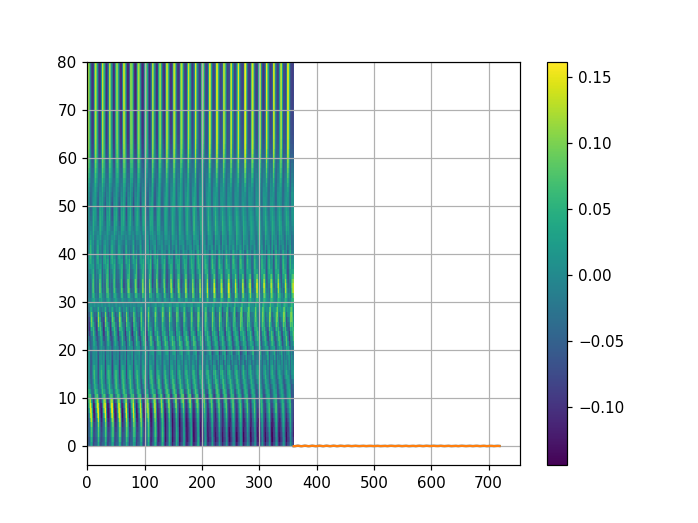

In [7]:
plt.pcolormesh(umoor.T); plt.colorbar()

<IPython.core.display.Javascript object>


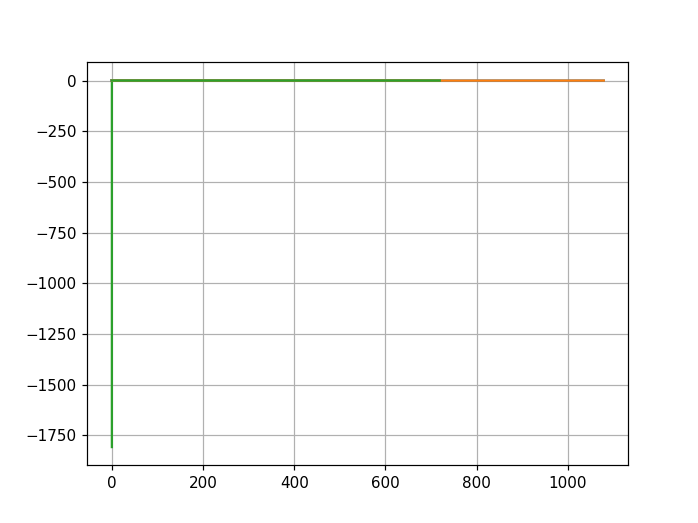

In [151]:
iz = -10

plt.plot(times,umoor[:,iz],times,uu[:,iz])
plt.grid(True)

In [5]:
tts = np.arange(len(times))
limsx = abs(umoor).max()*np.array([-1,1])

toplot = [umoor, uu]

fig = plt.figure()
ax = plt.gca()
it = tts[10]
data = np.c_[toplot[0][it,:], toplot[1][it,:]]
hpl = ax.plot(data,zz,'.-'); 
plt.grid(True)
ax.set_xlim(limsx)
ax.legend(['mooring', 'modal'])

def fanim(it):
    for hp,data in zip(hpl,[toplot[0][it,:], toplot[1][it,:]]):
        hp.set_xdata(data)
        

#plt.plot(umoor[it,:],zz,'.-',uu[it,:],zz,'.-'); plt.grid(True)

ani = FuncAnimation(fig, fanim, frames=tts, interval=200, repeat=False)


NameError: name 'umoor' is not defined

<IPython.core.display.Javascript object>


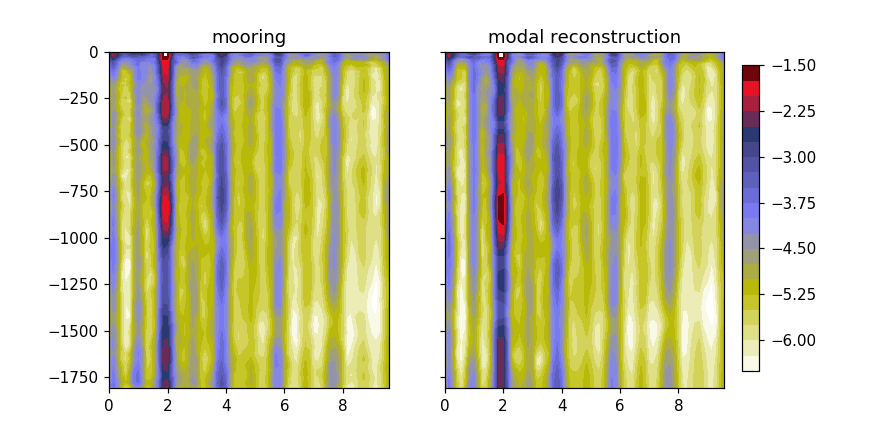

In [143]:
# spectra at each sigma level
dt = np.diff(times[:2])
Lwin = 7
nwindow = int(Lwin*24./dt)

fcut = 5/12.42*24

freq, psd = sig.welch(umoor, fs=24./dt, nperseg=nwindow, axis=0)
_, prov = sig.welch(vmoor, fs=24./dt, nperseg=nwindow, axis=0)
freq = freq[freq<=fcut]
Nf = len(freq)
psd = 0.5 * ( psd[:Nf,:].T + prov[:Nf,:].T )

_, psb = sig.welch(uu, fs=24./dt, nperseg=nwindow, axis=0)
_, prov = sig.welch(vv, fs=24./dt, nperseg=nwindow, axis=0)
psb = 0.5 * ( psb[:Nf,:].T + prov[:Nf,:].T )

del prov

vmin, vmax = -6.5, -1.5
levels = np.linspace(vmin, vmax, 21)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

hct = axs[0].contourf(freq, zz, np.log10(psd), levels, cmap="gist_stern_r")
axs[0].set_title('mooring')
hcb = axs[1].contourf(freq, zz, np.log10(psb), levels, cmap="gist_stern_r")
axs[1].set_title('modal reconstruction')
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(hct, cax=cbar_ax)

data read


<IPython.core.display.Javascript object>


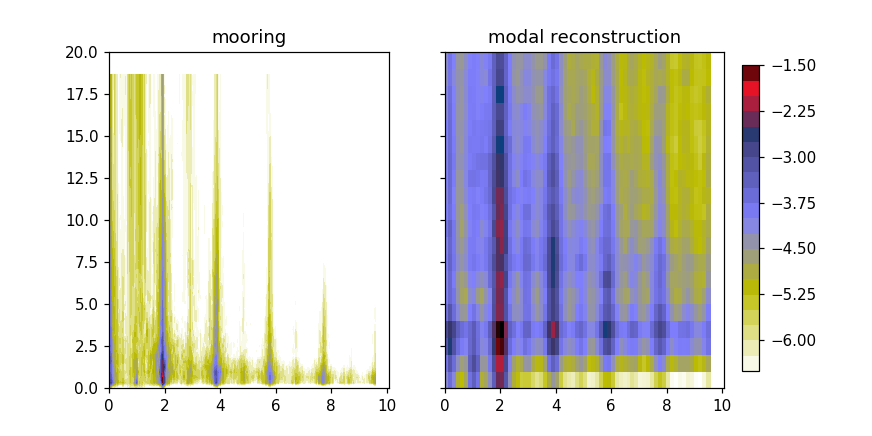

In [145]:
# 2D vertical modes / frequency spectra
nc = Dataset(mode_name, "r")
uamp = nc.variables['u_amp'][:,:,iy,ix]
vamp = nc.variables['v_amp'][:,:,iy,ix]
nc.close()
print('data read')

_, psm = sig.welch(uamp, fs=24./dt, nperseg=nwindow, axis=0)
_, prov = sig.welch(vamp, fs=24./dt, nperseg=nwindow, axis=0)
psm = 0.5 * ( psm[:Nf,:].T + prov[:Nf,:].T )

# 2D vertical fft / frequency spectra
Nzi = 120
zis = np.linspace(zz.min(), zz.max(), Nzi)
prov = itp.pchip(zz, umoor, axis=1)(zis)
psc = np.fft.rfft2(prov.T)
mods = np.fft.fftshift(np.fft.fftfreq(Nzi, d=np.diff(zis[:2])))
frqs = np.fft.rfftfreq(len(times), d=dt/24)

prov = itp.pchip(zz, vmoor, axis=1)(zis)
prov = np.fft.rfft2(prov.T)

psc = np.fft.fftshift(0.5*(np.abs(prov)**2 + np.abs(psc.conj())**2), axes=0)/prov.size**2/np.diff(frqs[:2])
fcut = 5/12.42*24
nf = np.where(frqs <= fcut)[0][-1]
psc, frqs = psc[:,:nf], frqs[:nf]
psc = psc[Nzi//2:,:] + psc[Nzi//2:0:-1,:]
psc[0] /= 2.
mods = mods[Nzi//2:]

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

hct = axs[0].contourf(frqs, mods*abs(zz[0])/np.pi, np.log10(psc), levels, cmap="gist_stern_r")
axs[0].set_title('mooring')
hcb = axs[1].pcolormesh(freq, np.arange(Nm+1), np.log10(psm), cmap="gist_stern_r")
axs[1].set_title('modal reconstruction')
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(hct, cax=cbar_ax)

<IPython.core.display.Javascript object>


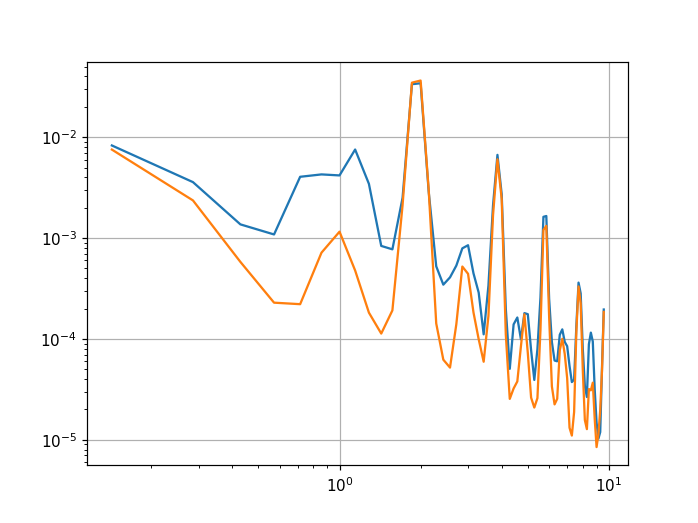

In [203]:
iz = 79

plt.figure()
plt.loglog(freq, psd[iz,:], freq, psb[iz,:])
plt.grid(True)

## Something else 
using gsw, for LUCKYT

In [192]:
dirpic = "pictures/CNES_for/"

<IPython.core.display.Javascript object>


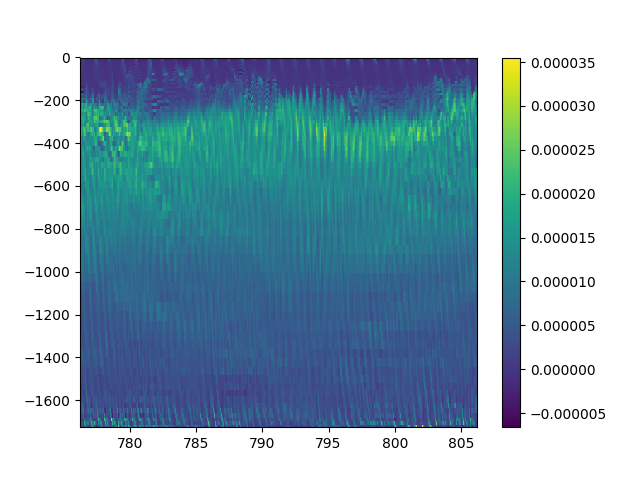

In [205]:
# compute mode
def tsz_to_rho(temp, salt, zrb, lat, lon, izref=2, what="sigma"):
    pres = gsw.p_from_z(zrb, lat)
    SA = gsw.SA_from_SP(salt, pres, lon, lat)
    CT = gsw.CT_from_pt(SA, temp)
    if what == "sigma":
        lafun = eval('gsw.sigma{}'.format(izref))
    elif what in ["bvf","Nsquared"]:
        lafun = lambda x,y: gsw.Nsquared(x, y, pres, lat=lat)
    else: # in-situ
        lafun = lambda x,y: gsw.rho(x,y,pres)
    return lafun(SA, CT)

ix, jy = 2, 2
lon = emoor.lon_rho[jy,ix]
lat = emoor.lat_rho[jy,ix]
zrb = emoor.zrb[:,jy,ix]
otime = emoor.scrum_time/3600/24
dt = float(np.diff(otime).mean())

bvf, pmid = tsz_to_rho(emoor.temp[:,:,jy,ix].T, emoor.salt[:,:,jy,ix].T, zrb[:,None], lat, lon, what="bvf")
pmid = pmid[:,0]
zmid = .5*(zrb[:-1]+zrb[1:])
zwb  = np.r_[emoor.zwb[0,jy,ix], zmid, emoor.zwb[-1,jy,ix]]

plt.figure()
plt.pcolormesh(otime, zrb, bvf)
plt.colorbar()

bvfmoy = itp.pchip(zmid, bvf.mean(axis=1), extrapolate=True)(zwb)

if season == "summer":
    inds, = np.where(zwb>-200)
    if (bvfmoy[inds]<0).any():
        ii = inds[np.where(bvfmoy[inds]<0)[0][0]]
        print("modifying:",ii, zwb[ii], bvfmoy[ii])
    bvfmod = bvfmoy.copy()
    bvfmod[ii:] = 0
else:
    bvfmod = bvfmoy

<IPython.core.display.Javascript object>


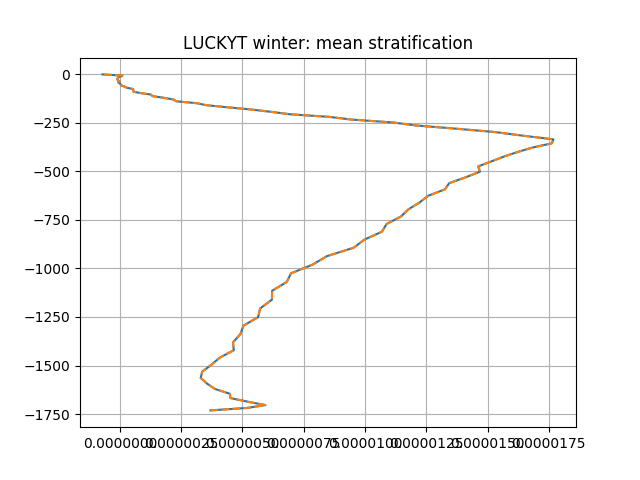

In [206]:
fig = plt.figure()
plt.plot(bvfmoy, zwb)
plt.plot(bvfmod, zwb, "--")
plt.grid(True)

plt.title(simul.upper()+" "+season+": mean stratification")

fig.savefig(dirpic+"{0}_{1}_bvfmoy.pdf".format(simul,season))

In [207]:
# compute modes
nmods = 10
# modes, lam, dzs = dynmodes(bvfmoy, zrb, nmods) # dynmodes does not work sometimes
(wmod, umod), lam, zcheb = chemodes(bvfmod, zwb, nmods)
umrb = itp.pchip(zcheb, umod)(zrb)
dzr = np.diff(zwb)
normu = (umrb**2*dzr[:,None]).sum(axis=0)

In [208]:
# project 

uu = emoor.u[:,:,jy,ix]
vv = emoor.v[:,:,jy,ix]
uamp = (uu[:,:,None]*umrb[None,:,:]*dzr[None,:,None]).sum(axis=1)/normu[None,:]
vamp = (vv[:,:,None]*umrb[None,:,:]*dzr[None,:,None]).sum(axis=1)/normu[None,:]

# filter at M2
fcut = 24/12.42*np.array([1/1.2, 1.2])
bb, aa = sig.butter(4, 2*dt*fcut, btype="band")
uabp = sig.filtfilt(bb, aa, sig.detrend(uamp, axis=0), method="gust", axis=0)
vabp = sig.filtfilt(bb, aa, sig.detrend(vamp, axis=0), method="gust", axis=0)
ufil = sig.filtfilt(bb, aa, sig.detrend(uu, axis=0), method="gust", axis=0)
vfil = sig.filtfilt(bb, aa, sig.detrend(vv, axis=0), method="gust", axis=0)

# RECONSTRUCT SIGNAL
def resig(amp,mod):
    return (amp[:,None,:]*mod[None,:,:]).sum(axis=-1)


<IPython.core.display.Javascript object>


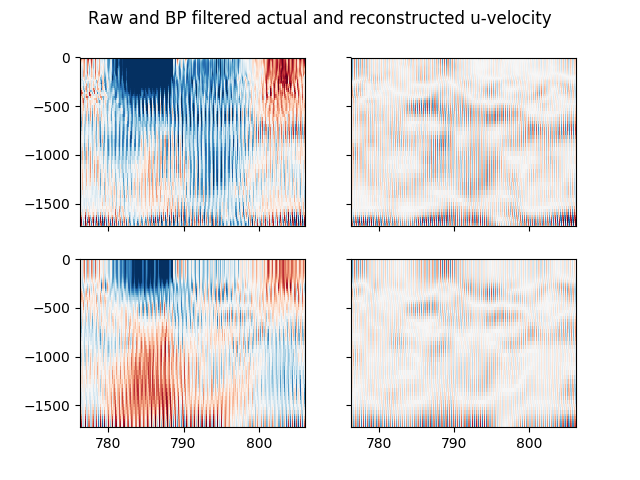

In [209]:
camp = .2
cmap = "RdBu_r"

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0,0].pcolormesh(otime, zrb, uu.T, vmin=-camp, vmax=camp, cmap=cmap)
axs[0,1].pcolormesh(otime, zrb, ufil.T, vmin=-camp, vmax=camp, cmap=cmap)
axs[1,0].pcolormesh(otime, zrb, resig(uamp,umrb).T, vmin=-camp, vmax=camp, cmap=cmap)
axs[1,1].pcolormesh(otime, zrb, resig(uabp,umrb).T, vmin=-camp, vmax=camp, cmap=cmap)
#plt.colorbar()

fig.suptitle("Raw and BP filtered actual and reconstructed u-velocity")

fig.savefig(dirpic+"{0}_{1}_umodrec.png".format(simul,season), mgnification="auto", bbox_inches="tight", dpi=150)

<IPython.core.display.Javascript object>


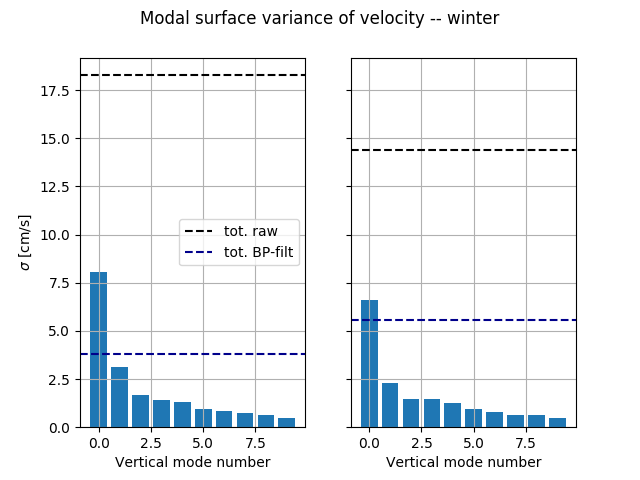

In [210]:
vafu = ufil[:,-1].std()
vafv = vfil[:,-1].std()
varu = uu[:,-1].std()
varv = vv[:,-1].std()
vanu = uamp.std(axis=0)*umrb[-1,:]
vanv = vamp.std(axis=0)*umrb[-1,:]

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
axs[0].bar(np.arange(nmods), vanu*100)
axs[0].axhline(varu*100, color="k", linestyle="--", label="tot. raw")
axs[0].axhline(vafu*100, color="darkblue", linestyle="--", label="tot. BP-filt")

axs[1].bar(np.arange(nmods), vanv*100)
axs[1].axhline(varv*100, color="k", linestyle="--")
axs[1].axhline(vafv*100, color="darkblue", linestyle="--")

for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Vertical mode number')
    
axs[0].set_ylabel(r'$\sigma$ [cm/s]')
fig.suptitle('Modal surface variance of velocity -- '+season)
axs[0].legend(loc="best")

fig.savefig(dirpic+"{0}_{1}_ModalVarUV.pdf".format(simul,season))

<IPython.core.display.Javascript object>


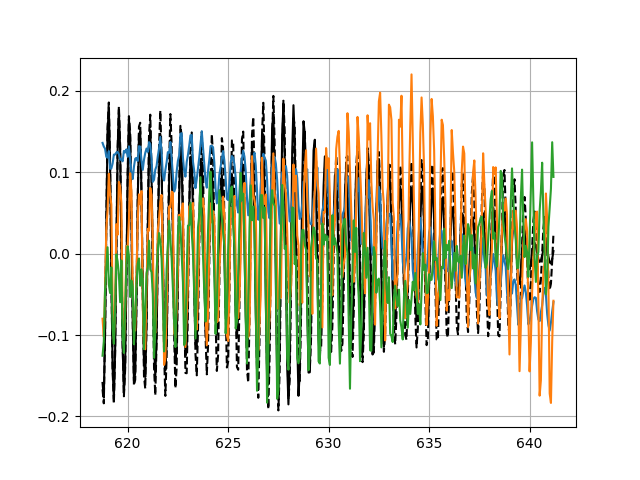

In [143]:
# variance
nmod = 3

plt.figure()
plt.plot(otime, ufil[:,-1], "k")
plt.plot(otime, urec[:,-1], "--k")
plt.plot(otime, uamp[:,:nmod]*umrb[-1:,:nmod])
plt.grid(True)

<IPython.core.display.Javascript object>


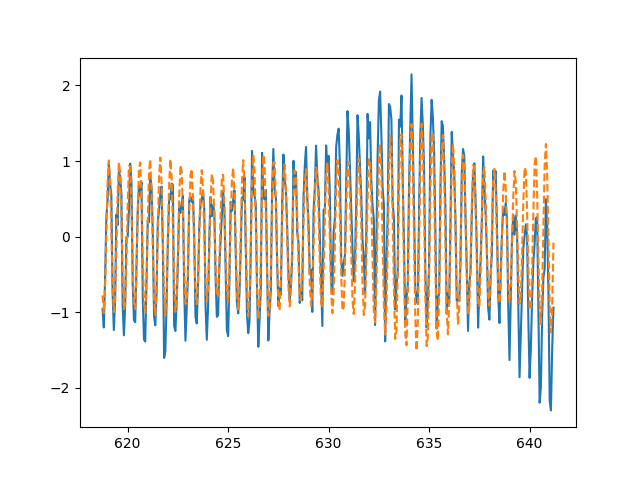

In [123]:
plt.figure()
plt.plot(otime, sig.detrend(uamp[:,1], axis=0))
plt.plot(otime, uabp[:,1], "--")